# Changepoint detection

Use PyMC3 to detected changes in the underlying distribution generating a sequence.

In [1]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import theano
import theano.tensor as T
import pymc3 as pm

sns.set_style('darkgrid')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

The series are defined by 2 [Poisson distributions](https://en.wikipedia.org/wiki/Poisson_distribution). With a different rate parameter $\lambda$. The average number of events in an interval is designated $\lambda$, which is the event rate.

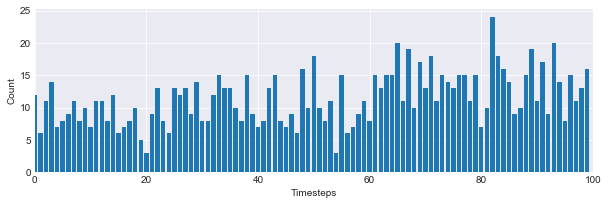

In [2]:
np.random.seed(42)

total_timesteps = 100
lmbd_1 = 10
lmbd_2 = 13
real_changepoint = 61
y = np.r_[np.random.poisson(lmbd_1, real_changepoint), np.random.poisson(lmbd_2, total_timesteps-real_changepoint)]
y_len = y.shape[0]

fig = plt.figure(figsize=(10, 3))
plt.bar(range(y_len), y)
plt.xlim([0, y_len])
plt.xlabel('Timesteps')
plt.ylabel('Count')
plt.show()

The parameter $\lambda$ from the Poission distribution can be any positive number. Put an [exponential](https://en.wikipedia.org/wiki/Exponential_distribution) prior on the lambdas. The Exponential is a special case of the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). The exponential also has a scale hyperparameter which corresponds to $\lambda$ from the Poisson distribution and is typically set to the average of the count data. The inverse of the scale parameter is also known as the rate parameter, which is the `lam` parameter in PyMC3's `Exponential`.

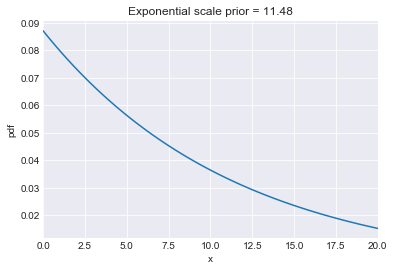

In [3]:
exp_scale = y.mean()

fig, ax = plt.subplots(1, 1)
prior_beta = stats.expon(scale=exp_scale)
x = np.linspace(0, 20, 100)
ax.plot(x, prior_beta.pdf(x))
plt.title('Exponential scale prior = {}'.format(exp_scale))
plt.xlabel('x')
plt.xlim([0, 20])
plt.ylabel('pdf')
plt.show()

Use [uniform](https://en.wikipedia.org/wiki/Discrete_uniform_distribution) prior belief over all timesteps for changepoint.

In [4]:
timesteps = range(y_len)

with pm.Model() as model:
    # Exponential priors
    lambda_1 = pm.Exponential('lambda_1', lam=1/exp_scale)
    lambda_2 = pm.Exponential('lambda_2', lam=1/exp_scale)
    lambda_diff = pm.Deterministic('lambda_diff', lambda_2 - lambda_1)
    # Change point
    changepoint = pm.DiscreteUniform('changepoint', lower=0, upper=y_len, testval=y_len//2)
    # First distribution is strictly before the other
    lamda_selected = T.switch(timesteps < changepoint, lambda_1, lambda_2)
    # Observations come from Poission distributions with one of the priors
    obs = pm.Poisson('obs', mu=lamda_selected, observed=y)

In [5]:
niter = 10000

with model:
    step = pm.Metropolis()
    trace = pm.sample(niter, step, random_seed=42, progressbar=True)

100%|██████████| 10500/10500 [00:04<00:00, 2462.65it/s]


trace:  (10000,)


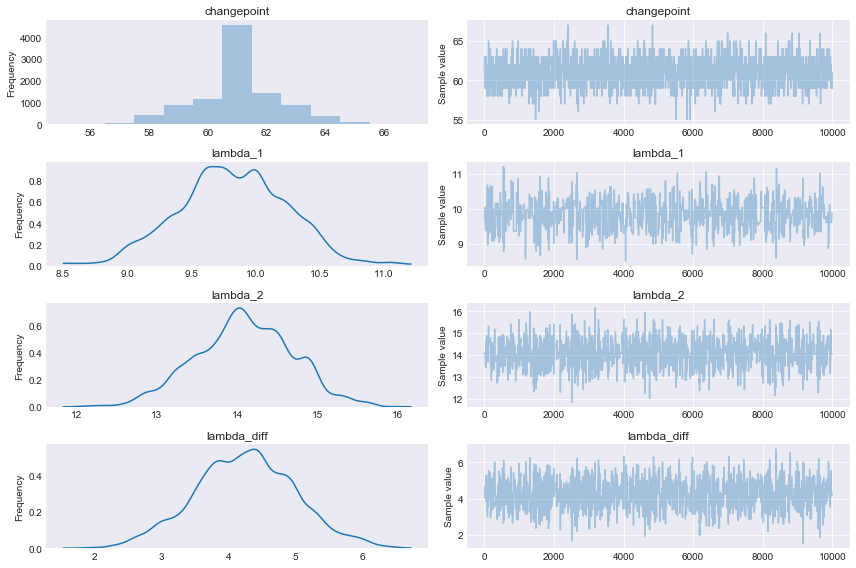

In [6]:
print('trace: ', trace['changepoint'].shape)
pm.traceplot(trace)
plt.show()

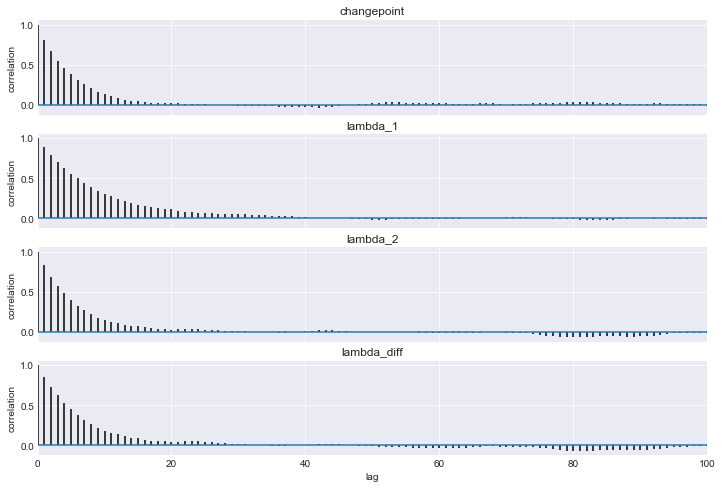

In [7]:
pm.autocorrplot(trace)
plt.show()

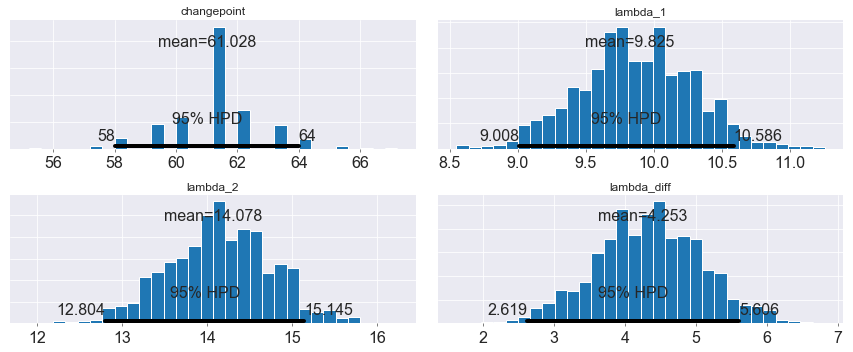

In [8]:
pm.plot_posterior(trace)
plt.show()

## Try to detect change point over time

Simulate a process to detect the changepoint over time. New observations are added to the observed sequence over time. We want to know when there was a change.

In [9]:
# Initialise model

y_start = 10
max_y_shared = theano.shared(y_start)
y_shared = theano.shared(y)
print('max_y_shared: ', max_y_shared.eval())
print('y_shared: ', y_shared.shape.eval())

timesteps_shared = theano.shared(np.array(list(range(len(y)))))
print('timesteps_shared: ', timesteps_shared.shape.eval())

y_sub = y_shared[0:max_y_shared]
t_sub = timesteps_shared[0:max_y_shared]
print('y_sub: ', y_sub.eval())
print('t_sub: ', t_sub.eval())

with pm.Model() as model:
    # Exponential priors
    lambda_1 = pm.Exponential('lambda_1', lam=1/exp_scale)
    lambda_2 = pm.Exponential('lambda_2', lam=1/exp_scale)
    # Change point
    changepoint = pm.DiscreteUniform('changepoint', lower=0, upper=max_y_shared, testval=max_y_shared // 2)
    # First distribution is strictly before the other
    lamda_selected = T.switch(t_sub < changepoint, lambda_1, lambda_2)
    lambda_diff = pm.Deterministic('lambda_diff', lambda_2 - lambda_1)
    # Observations come from Poission distributions with one of the priors
    obs = pm.Poisson('obs', mu=lamda_selected, observed=y_sub)

max_y_shared:  10
y_shared:  [100]
timesteps_shared:  [100]
y_sub:  [12  6 11 14  7  8  9 11  8 10]
t_sub:  [0 1 2 3 4 5 6 7 8 9]


In [10]:
# Initial sampling (burn-in)
niter = 2500

with model:
    step = pm.Metropolis()
    trace = pm.sample(niter, step, tune=5000, random_seed=42, progressbar=True)

100%|██████████| 7500/7500 [00:02<00:00, 2692.21it/s]


In [11]:
# Sample traces over timesteps
lengths = range(y_start, total_timesteps)
traces = []
for l in tqdm(lengths):
    max_y_shared.set_value(l)
    with model:
        step = pm.Metropolis()
        trace = pm.sample(niter+500, step, trace=trace, random_seed=42, progressbar=False)
    traces.append(trace[-niter:])

100%|██████████| 90/90 [02:19<00:00,  1.55s/it]


In [12]:
# Find first timestep where 0 is not in the 95% interval
lambda_diff_mean_trace = [t['lambda_diff'].mean() for t in traces]
lambda_diff_lb_trace = [np.percentile(t['lambda_diff'], 2.5) for t in traces]
lambda_diff_up_trace = [np.percentile(t['lambda_diff'], 97.5) for t in traces]

detected_changepoint = next(l for l, lb, up in zip(lengths, lambda_diff_lb_trace, lambda_diff_up_trace) if not (lb <= 0 <= up))
print('Change detected at timestep {}. (real changepoint = {})'.format(detected_changepoint, real_changepoint))

Change detected at timestep 66. (real changepoint = 61)


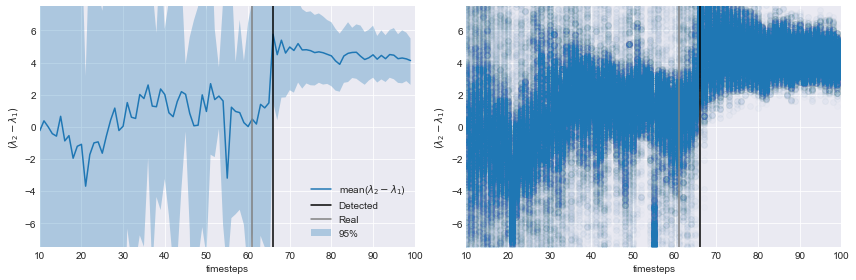

In [13]:
# Plot the distribution of lambda diff over the timesteps
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# Mean and 95% interval
ax1.plot(lengths, lambda_diff_mean_trace, label='mean($\lambda_2 - \lambda_1$)')
ax1.fill_between(lengths, lambda_diff_lb_trace, lambda_diff_up_trace, alpha=.3, label='95%')
ax1.axvline(x=detected_changepoint, color='black', label='Detected')
ax1.axvline(x=real_changepoint, color='grey', label='Real')
ax1.set_xlim([y_start, total_timesteps])
ax1.set_ylim([-7.5, 7.5])
ax1.set_xlabel('timesteps')
ax1.set_ylabel('$(\lambda_2 - \lambda_1)$')
ax1.legend(loc=4)

# Plot samples
x, y = zip(*[(l, tp) for i, l in enumerate(lengths) for tp in traces[i]['lambda_diff']])
ax2.scatter(x, y, alpha=.01)
ax2.axvline(x=detected_changepoint, color='black', label='Detected')
ax2.axvline(x=real_changepoint, color='grey', label='Real')
ax2.set_xlabel('timesteps')
ax2.set_ylabel('$(\lambda_2 - \lambda_1)$')
ax2.set_xlim([y_start, total_timesteps])
ax2.set_ylim([-7.5, 7.5])

plt.tight_layout()
plt.show()

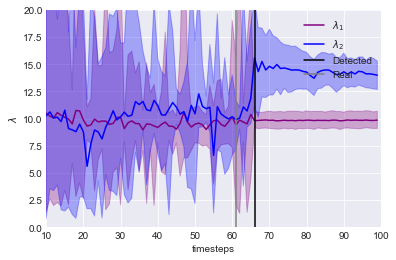

In [14]:
plt.plot(lengths, [t['lambda_1'].mean() for t in traces], label='$\lambda_1$', color='purple')
plt.fill_between(
    lengths, 
    [np.percentile(t['lambda_1'], 2.5) for t in traces], 
    [np.percentile(t['lambda_1'], 97.5) for t in traces], 
    alpha=.3, color='purple')
plt.plot(lengths, [t['lambda_2'].mean() for t in traces], label='$\lambda_2$', color='blue')
plt.fill_between(
    lengths, 
    [np.percentile(t['lambda_2'], 2.5) for t in traces], 
    [np.percentile(t['lambda_2'], 97.5) for t in traces], 
    alpha=.3, color='blue')
plt.axvline(x=detected_changepoint, color='black', label='Detected')
plt.axvline(x=real_changepoint, color='grey', label='Real')
plt.xlim([y_start, total_timesteps])
plt.ylim([0, 20])
plt.xlabel('timesteps')
plt.ylabel('$\lambda$')
plt.legend(loc=1)
plt.show()

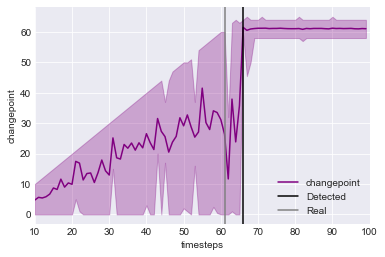

In [15]:
plt.plot(lengths, [t['changepoint'].mean() for t in traces], label='changepoint', color='purple')
plt.fill_between(
    lengths, 
    [np.percentile(t['changepoint'], 2.5) for t in traces], 
    [np.percentile(t['changepoint'], 97.5) for t in traces], 
    alpha=.3, color='purple')
plt.axvline(x=detected_changepoint, color='black', label='Detected')
plt.axvline(x=real_changepoint, color='grey', label='Real')
plt.xlim([y_start, total_timesteps])
plt.xlabel('timesteps')
plt.ylabel('changepoint')
plt.legend(loc=4)
plt.show()